## 1. Imports


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import deeplake
import random
from lib.dataset import peek_labels

print(tf.__version__)


2.15.0


d:\Programming\Projects\Public\plant-lens\ai\scripts\maker\.venv\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.17) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


## 2. Load Dataset


In [14]:
ROOT_PATH = "D:/Programming/Projects/Public/plant-lens/ai"
DATASET_DATA_PATH = f"{ROOT_PATH}/data/dataset"
DEVELOPMENT_MODEL_PATH = f"{ROOT_PATH}/model/develop"

VERSION_TAG = "0.4.2-80"
BUILD_MODEL = False

raw_training_dataset = deeplake.load(f'{DATASET_DATA_PATH}/training')
raw_validation_dataset = deeplake.load(f'{DATASET_DATA_PATH}/validation')
raw_testing_dataset = deeplake.load(f'{DATASET_DATA_PATH}/testing')

raw_training_dataset.summary()
raw_validation_dataset.summary()
raw_testing_dataset.summary()

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/training loaded successfully.



D:/Programming/Projects/Public/plant-lens/ai/data/dataset/validation loaded successfully.

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/testing loaded successfully.

Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/training', tensors=['images', 'labels'])

 tensor      htype            shape           dtype  compression
 -------    -------          -------         -------  ------- 
 images      image     (11218, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (11218, 1)       uint16    None   
Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/validation', tensors=['images', 'labels'])

 tensor      htype            shape          dtype  compression
 -------    -------          -------        -------  ------- 
 images      image     (1608, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (1608, 1)       uint16    None   
Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/testing', tenso

In [3]:
DIMENSIONS = 224
BATCH_SIZE = 48
AUTOTUNE = tf.data.experimental.AUTOTUNE
STEPS_PER_EPOCH = 10
EPOCHS = 5
LEARNING_RATE = 0.0001

In [4]:
data_classes = list(set(sum(raw_training_dataset.labels.data()['text'], [])))
data_classes_count = len(data_classes)

print("Total Number of Classes", data_classes_count)

Total Number of Classes 28


### 2.2 Create Data Pipeline


In [5]:
raw_training_dataset = raw_training_dataset.tensorflow()
raw_validation_dataset = raw_validation_dataset.tensorflow()
raw_testing_dataset = raw_testing_dataset.tensorflow()

In [6]:
def group_dataset(raw_dataset):
    data_by_label = {}

    for data in raw_dataset:
      label = data['labels'].numpy().item()
      if label not in data_by_label:
          data_by_label[label] = []
      data_by_label[label].append(data['images'])

    return data_by_label

grouped_training_dataset = group_dataset(raw_training_dataset)
grouped_validation_dataset = group_dataset(raw_validation_dataset)
grouped_testing_dataset = group_dataset(raw_testing_dataset)

def data_generator(steps_per_epoch, dataset):
    grouped_dataset = None
    match dataset.decode():
        case "training":
            grouped_dataset = grouped_training_dataset
        case "validation":
            grouped_dataset = grouped_validation_dataset
        case "testing":
            grouped_dataset = grouped_testing_dataset

    steps = 0
    while(steps_per_epoch * BATCH_SIZE > steps):
        sampled_label = random.randint(0, data_classes_count - 1)

        yield {'images': random.choice(grouped_dataset.get(sampled_label, [])),
               'labels': sampled_label}
        
        steps += 1
        
""" for value in data_generator(5,"training".encode()):  
    print(value["images"].shape, value["labels"].shape)
"""

def generate_dataset(dataset):
  return tf.data.Dataset.from_generator(data_generator, args=(STEPS_PER_EPOCH,dataset,), output_signature={
      'images': tf.TensorSpec(shape=(DIMENSIONS, DIMENSIONS, 3), dtype=tf.uint8),
      'labels': tf.TensorSpec(shape=(), dtype=tf.uint8),
  })

def augment(image):
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.4, upper=0.8)
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_flip_left_right(image)
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_flip_up_down(image)

    return image

# Define a preprocessing function
def preprocess_data(augmentation=False):
    def wrapper(args) -> tuple:
        label = args['labels']

        image = augment(args['images']) if augmentation else args['images']
        image = tf.cast(image, tf.float32)
        image = tf.math.divide(image, 255.0)

        return image, label
    return wrapper

In [7]:
training_dataset = generate_dataset('training').map(preprocess_data(augmentation=True), num_parallel_calls=AUTOTUNE)
validation_dataset = generate_dataset('validation').map(preprocess_data(), num_parallel_calls=AUTOTUNE)
testing_dataset = generate_dataset('testing').map(preprocess_data(), num_parallel_calls=AUTOTUNE)

# Shuffle and batch the datasets
training_dataset = training_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
testing_dataset = testing_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [8]:
for images, labels in training_dataset.take(1):
    print("Training Batch images shape:", images.shape)
    print("Training Batch labels shape:", labels.shape)

for images, labels in validation_dataset.take(1):
    print("Validation Batch images shape:", images.shape)
    print("Validation Batch labels shape:", labels.shape)

for images, labels in testing_dataset.take(1):
    print("Testing Batch images shape:", images.shape)
    print("Testing Batch labels shape:", labels.shape)

Training Batch images shape: (48, 224, 224, 3)
Training Batch labels shape: (48,)
Validation Batch images shape: (48, 224, 224, 3)
Validation Batch labels shape: (48,)
Testing Batch images shape: (48, 224, 224, 3)
Testing Batch labels shape: (48,)


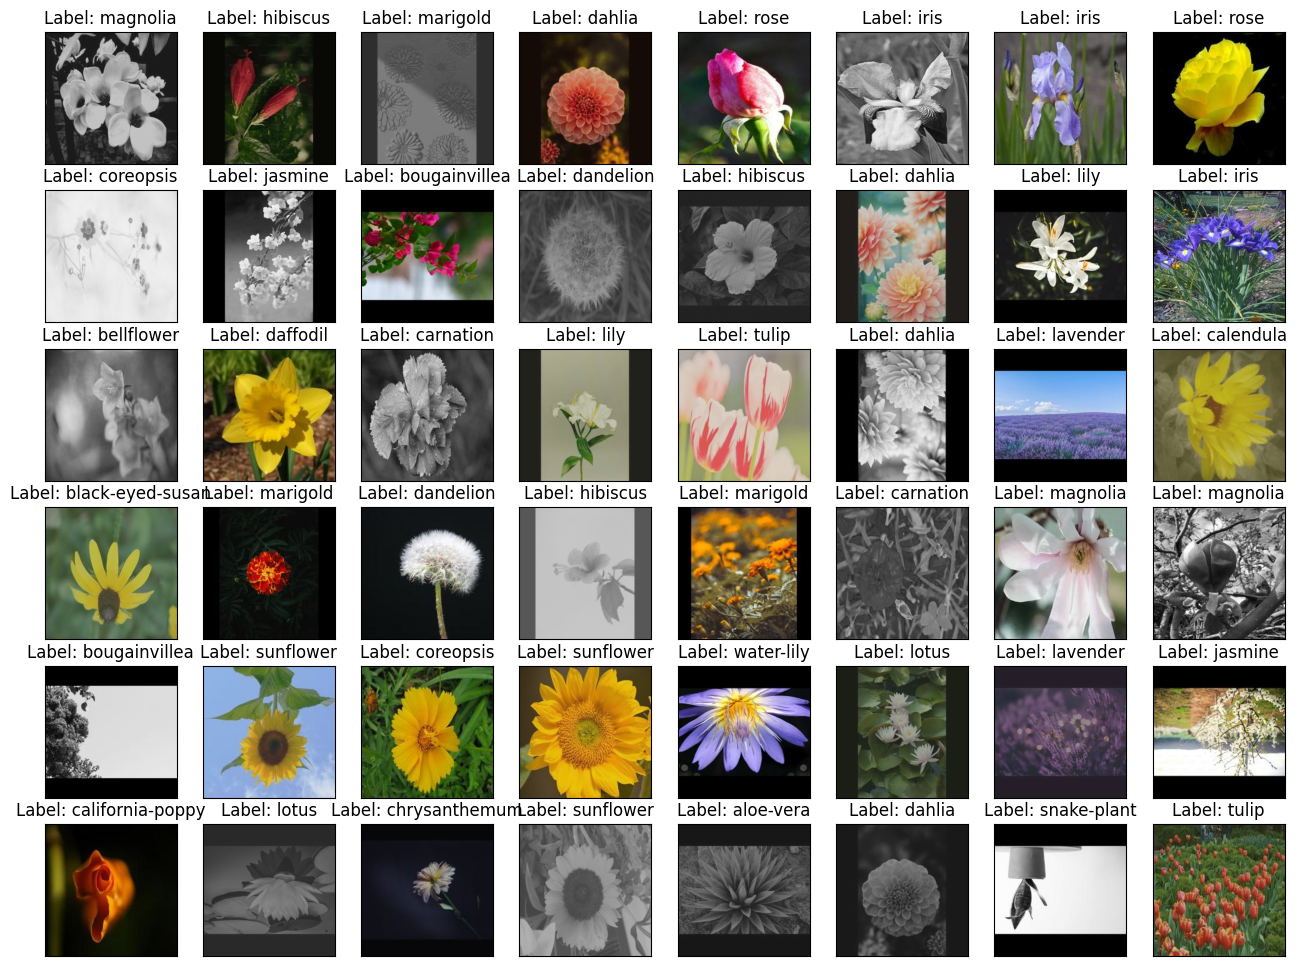

In [9]:
class_names = ['aloe-vera', 'astilbe', 'bellflower', 'black-eyed-susan', 'bougainvillea', 'calendula', 'california-poppy', 'carnation', 'chrysanthemum', 'common-daisy', 'coreopsis', 'daffodil',
               'dahlia', 'dandelion', 'golden-barrel-cactus', 'hibiscus', 'iris', 'jasmine', 'lavender', 'lily', 'lotus', 'magnolia', 'marigold', 'rose', 'snake-plant', 'sunflower', 'tulip', 'water-lily']

peek_labels(training_dataset, class_names=class_names)

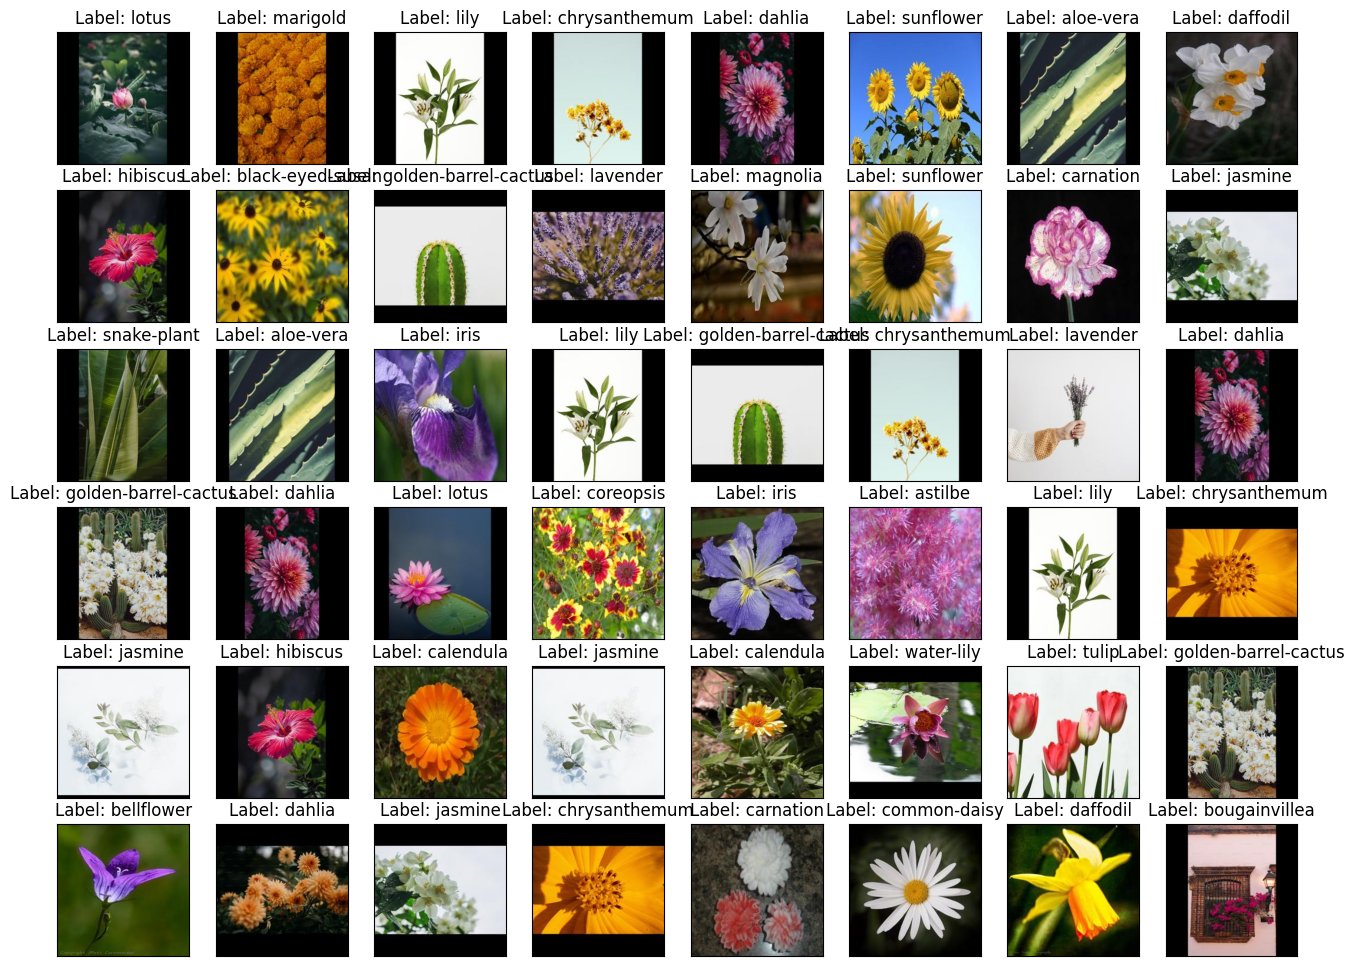

In [10]:
peek_labels(validation_dataset, class_names=class_names)

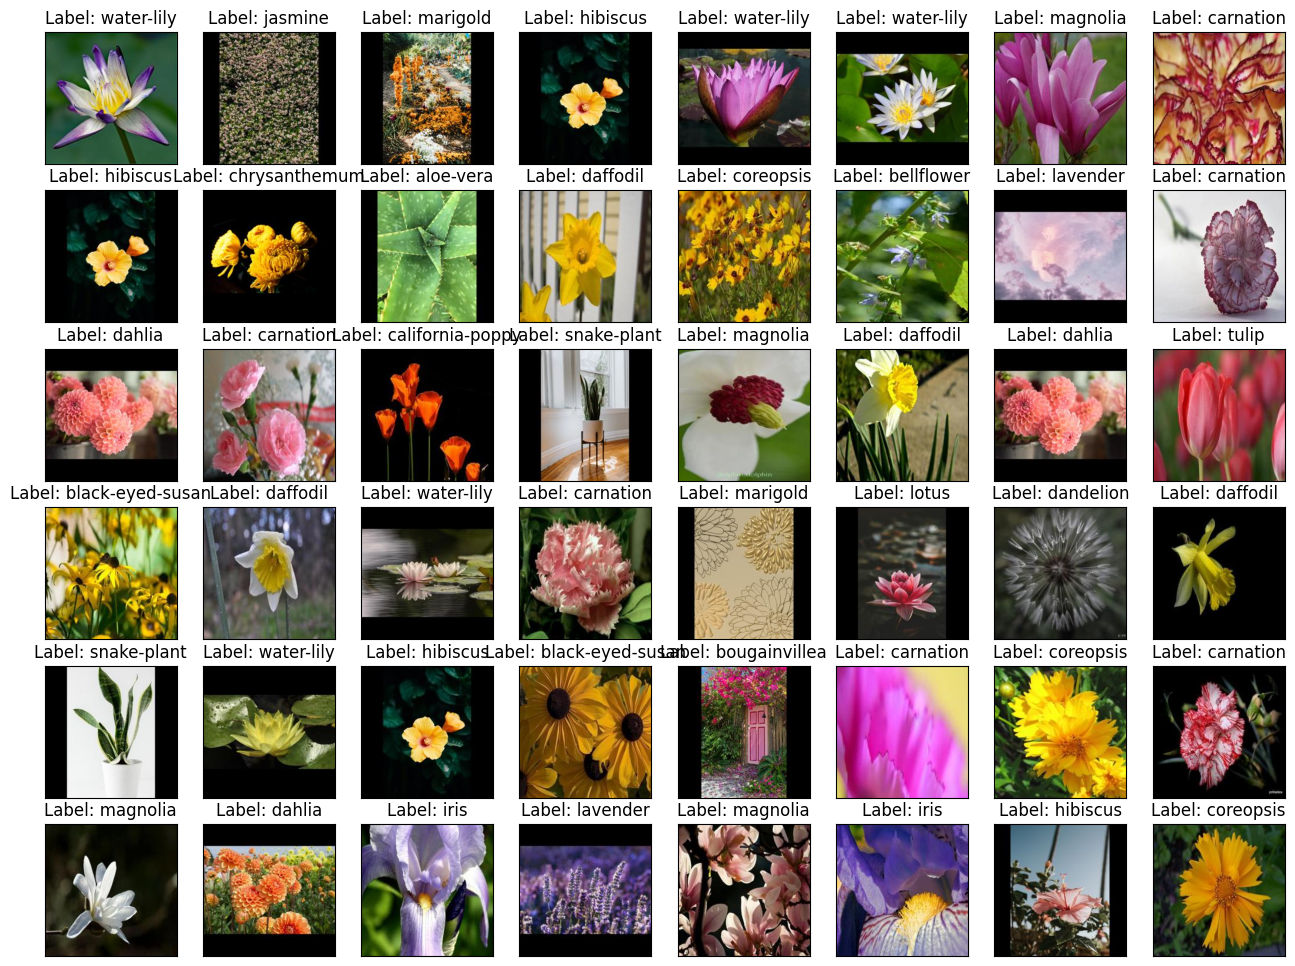

In [11]:
peek_labels(testing_dataset, class_names=class_names)

## 3. Build Model


In [15]:
from tensorflow.keras import Model, layers, optimizers, models, callbacks, applications
import tensorflow_hub as hub

def build_feature_extractor(build_model=BUILD_MODEL, version=VERSION_TAG, feature_size=1024):
    if not build_model:
        return models.load_model(f'{DEVELOPMENT_MODEL_PATH}/feature-extractor-v{version}.keras')
    
    input_layer = layers.Input(shape=(DIMENSIONS, DIMENSIONS, 3))
    feature_extractor = applications.mobilenet_v2.MobileNetV2(
        input_shape=(DIMENSIONS, DIMENSIONS, 3),
        include_top=False,
        weights='imagenet'
    )
    feature_extractor.trainable = True
    # feature_extractor = hub.KerasLayer('https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5', trainable=True)(input_layer)
    # flatten_layer = layers.Flatten()(feature_extractor)
    feature_extractor = feature_extractor(input_layer, training=True)
    flatten_layer = layers.GlobalAveragePooling2D()(feature_extractor)
    output_layer = layers.Dense(feature_size, activation='sigmoid')(flatten_layer)

    return Model(inputs=input_layer, outputs=output_layer, name="feature_extractor")

def build_categorical_classifier(build_model=BUILD_MODEL, version=VERSION_TAG, feature_size=1024):
    if not build_model:
        return models.load_model(f'{DEVELOPMENT_MODEL_PATH}/categorical-classifier-v{version}.keras')

    input_layer = layers.Input(shape=(feature_size))
    hidden_layer = layers.Dense(128, activation='relu')(input_layer)
    dropout_layer = layers.Dropout(0.2)(hidden_layer)
    hidden_layer = layers.Dense(64, activation='relu')(dropout_layer)
    dropout_layer = layers.Dropout(0.2)(hidden_layer)
    hidden_layer = layers.Dense(32, activation='relu')(dropout_layer)
    dropout_layer = layers.Dropout(0.2)(hidden_layer)
    output_layer = layers.Dense(data_classes_count, activation='softmax')(dropout_layer)

    return Model(inputs=input_layer, outputs=output_layer, name="categorical-classifier")

feature_extractor_model = build_feature_extractor()
categorical_classifier_model = build_categorical_classifier()

def build_model():
    input_layer = layers.Input(shape=(DIMENSIONS, DIMENSIONS, 3))

    feature_layer = feature_extractor_model(input_layer)
    output_layer = categorical_classifier_model(feature_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name="classifier")

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model = build_model()

model.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Functio  (None, 1024)              3569728   
 nal)                                                            
                                                                 
 categorical-classifier (Fu  (None, 28)                142460    
 nctional)                                                       
                                                                 
Total params: 3712188 (14.16 MB)
Trainable params: 3678076 (14.03 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


## 4. Train Model


In [16]:
%%time

VERSION = "0.3.1"
CHECKPOINT_MODEL_PATH = f"{ROOT_PATH}/model/checkpoint/{VERSION}"

checkpoint_callback = callbacks.ModelCheckpoint(filepath=CHECKPOINT_MODEL_PATH, save_weights_only=True, verbose=1)
# callbacks=[checkpoint_callback]
# Train the model
history = model.fit(training_dataset, epochs=EPOCHS, validation_data=validation_dataset)


Epoch 1/5


10/10 [==============================] - 42s 4s/step - loss: 1.8530 - accuracy: 0.4521 - val_loss: 1.9735 - val_accuracy: 0.5167
Epoch 2/5
10/10 [==============================] - 33s 3s/step - loss: 1.6981 - accuracy: 0.5083 - val_loss: 1.7189 - val_accuracy: 0.5938
Epoch 3/5
10/10 [==============================] - 32s 3s/step - loss: 1.7614 - accuracy: 0.4875 - val_loss: 1.6863 - val_accuracy: 0.6083
Epoch 4/5
10/10 [==============================] - 33s 3s/step - loss: 1.6540 - accuracy: 0.5375 - val_loss: 1.6362 - val_accuracy: 0.6313
Epoch 5/5
10/10 [==============================] - 32s 3s/step - loss: 1.5587 - accuracy: 0.5417 - val_loss: 1.6994 - val_accuracy: 0.6208
CPU times: total: 4min 45s
Wall time: 2min 52s


### 4.2 Training Result



initial | Training loss: 1.8530 | Validation Loss: 1.9735 || Training Accuracy: 45.21 % | Validation Accuracy: 51.67 %
 latest | Training loss: 1.5587 | Validation Loss: 1.6994 || Training Accuracy: 54.17 % | Validation Accuracy: 62.08 %


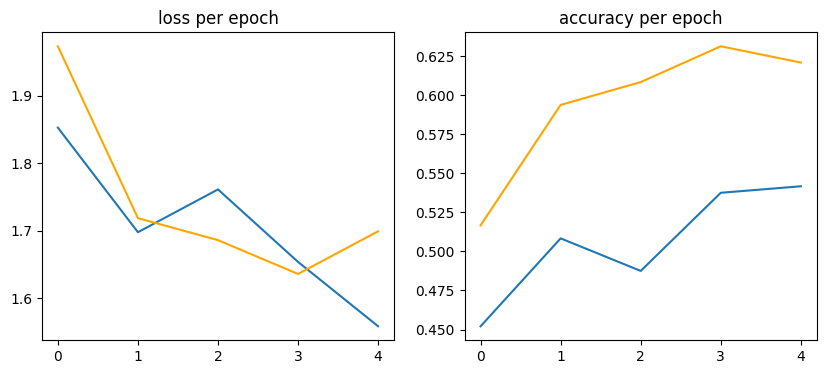

In [17]:
# access metrics from training history
print("\ninitial | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(
    history.history["loss"][0], history.history["val_loss"][0], history.history["accuracy"][0] * 100, history.history["val_accuracy"][0] * 100))
print(" latest | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(
    history.history["loss"][-1], history.history["val_loss"][-1], history.history["accuracy"][-1] * 100, history.history["val_accuracy"][-1] * 100))

fig, axis = plt.subplots(1, 2, figsize=(10, 4))
# plot loss
axis[0].plot(history.history["loss"])
axis[0].plot(history.history["val_loss"], color='orange')
axis[0].set_title("loss per epoch")
# plot accuracy
axis[1].plot(history.history["accuracy"])
axis[1].plot(history.history["val_accuracy"], color='orange')
axis[1].set_title("accuracy per epoch")
plt.show()

## 5. Test Model


In [18]:
# Evaluate the model
test_loss, test_acc = model.evaluate(testing_dataset)

print('Test loss:', test_loss, 'Test accuracy:', test_acc)

10/10 [==============================] - 11s 1s/step - loss: 1.7290 - accuracy: 0.5604
Test loss: 1.7290090322494507 Test accuracy: 0.5604166388511658


## 6. Visualize Result


10/10 [==============================] - 11s 1s/step


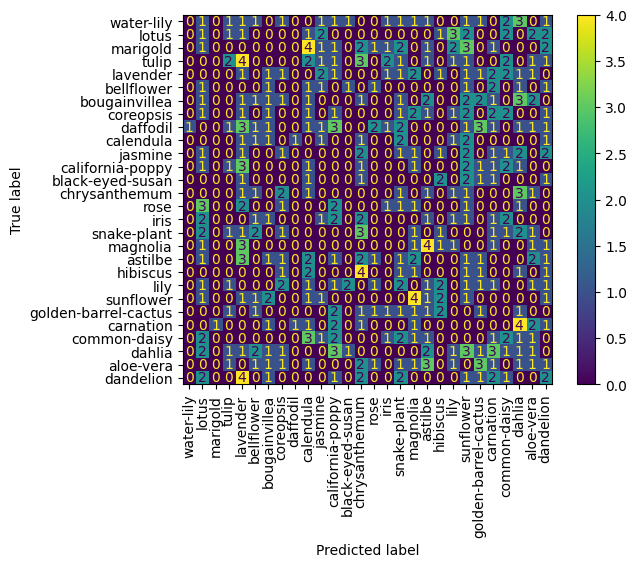

In [19]:
from sklearn import metrics

true_labels = tf.reshape([labels for _, labels in testing_dataset], [-1]).numpy()

predictions = model.predict(testing_dataset)
predicted_labels = tf.math.argmax(predictions, axis=1).numpy()

confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=data_classes)

cm_display.plot()

# Rotate x-axis labels by 15 degrees
plt.xticks(rotation=90)
plt.show()

## 7. Save Model


In [22]:
BUILD_MODEL = True
VERSION_TAG = input("Enter Version Tag (e.g 0.0.0):") + f"-{int(test_acc * 100)}" if BUILD_MODEL else VERSION_TAG  # "0.0.0"

models.save_model(feature_extractor_model, f'{DEVELOPMENT_MODEL_PATH}/feature-extractor-v{VERSION_TAG}.keras', save_format="keras")
models.save_model(categorical_classifier_model, f'{DEVELOPMENT_MODEL_PATH}/categorical-classifier-v{VERSION_TAG}.keras', save_format="keras")

models.save_model(model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.h5', save_format="h5")
# models.save_model(model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.keras', save_format="keras")
# models.save_model(model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}', save_format="tf")

C:\Users\shirs\AppData\Local\Temp\ipykernel_28124\2896795218.py:7: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  models.save_model(model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.h5', save_format="h5")
